# Final Tutorial: The Happiness Project

## Intro
This project is a collaboration between Matt Catalano and Eli Mendels for our Data Science class with Nick Mattei. In it we will be examining what metrics correspond to national happiness and then trying to predict which counties in the US will be the happiest.

### Housekeeping Stuff

In [1]:
#Importing all the necesary libraries. 
import sqlite3
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import re
#The below is for formatting and taken from past labs written by Nick Mattei
#This lets us show plots inline and also save PDF plots if we want them
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('fivethirtyeight')

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Show all the rows of a dataframe
pd.options.display.max_rows = 10000
pd.options.display.width = 1000

## Examining the Country Data
In looking at the country data, the first step is to read it into a dataframe. Once the data has been read, we will clean it to prepare it for analysis and add any other data that we deem important. Finally, once it is in an easy to manipulate form we will do some simple exploratory analysis of the final dataframe.

### Reading in the Data
Most of our country data will come from the CIA world factbook. We got the data in csv format from https://github.com/thewiremonkey/factbook.csv. 
The data is formatted in a collection of spreadsheets each of which contains three columns: an rank, the name, and the value. Each spreadsheet contains one measurement, for example population so they must be iterated over and then each spreadsheet must be joined on name to the cumulative table.

In [2]:
#Reading in a summary of the csv files
categories_df = pd.read_csv('categories.csv')
categories_df.head()

,Num,Category,Name
0,2147,Geography,Area
1,2119,People and Society,Population
2,2002,People and Society,Population growth rate
3,2054,People and Society,Birth rate
4,2066,People and Society,Death rate


In [3]:
csv_string = 'WorldFactBookData/c'
#Temporary dataframe to store csvs that need to be added to the dataframe. It's used here to ge the names of each countrty
df_to_add = pd.read_csv('WorldFactBookData/c2147.csv')
#Creating the dataframe with just the names
factbook_df = pd.DataFrame({'Name' : df_to_add['Name']})


In [4]:
#file_name = csv_string  + '2119' + '.csv'
#df_to_add = pd.read_csv(file_name)
#df_to_add = df_to_add.drop(columns=['Pos'])
#column_name = 'Population'
#df_to_add = df_to_add.rename(columns={"Value": column_name})
#factbook_df = factbook_df.merge(df_to_add, how = 'left')
#factbook_df

In [5]:
#Iterating through each file code in the categories list and adding the csv to the dataframe
for index, row in categories_df.iterrows():
    file_name = csv_string  + str(row['Num']) + '.csv'
    df_to_add = pd.read_csv(file_name)
    df_to_add = df_to_add.drop(columns=['Pos'])
    column_name = row['Name']
    df_to_add = df_to_add.rename(columns={"Value": column_name})
    factbook_df = factbook_df.merge(df_to_add, how = 'left')

In [6]:
factbook_df.head()

,Name,Area,Population,Population growth rate,Birth rate,Death rate,Net migration rate,Maternal mortality rate,Infant mortality rate,Life expectancy at birth,...,Natural gas - imports,Natural gas - proved reserves,Telephones - fixed lines,Telephones - mobile cellular,Internet users,Airports,Railways,Roadways,Waterways,Military expenditures
0,Russia,17098242,1.424238e+08,-0.04,11.60,13.69,1.69,34.0,6.97,70.47,...,8.200000e+09,4.780000e+13,39430000.0,2.210000e+08,84400000.0,1218.0,87157.0,1283387.0,102000.0,3.49
1,Canada,9984670,3.509984e+07,0.75,10.28,8.42,5.66,12.0,4.65,81.76,...,2.670000e+10,1.889000e+12,16600000.0,2.950000e+07,32400000.0,1467.0,46552.0,1042300.0,636.0,1.24
2,United States,9826675,3.213689e+08,0.78,12.49,8.15,3.86,21.0,5.87,79.68,...,8.163000e+10,8.734000e+12,129400000.0,3.174000e+08,276600000.0,13513.0,224792.0,6586610.0,41009.0,4.35
3,China,9596960,1.367485e+09,0.45,12.49,7.53,-0.44,37.0,12.44,75.41,...,5.190000e+10,3.300000e+12,249400000.0,1.300000e+09,626600000.0,507.0,86000.0,4106387.0,110000.0,1.99
4,Brazil,8514877,2.042598e+08,0.77,14.46,6.58,-0.14,56.0,18.60,73.53,...,1.385000e+10,3.887000e+11,44100000.0,2.807000e+08,108200000.0,4093.0,28538.0,1580964.0,50000.0,1.47


In [7]:
happiness_df = pd.read_csv('2015.csv')

In [8]:
happiness_df.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [9]:
#An initial merge to find which countries names need to be manually changed for the match. Since this is a low number it will be address manually
prelim_merge = happiness_df.merge(factbook_df, how = 'left', left_on = 'Country', right_on = 'Name')
countries_to_match = prelim_merge[prelim_merge['Area'].isnull()]
countries_to_match

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),...,Natural gas - imports,Natural gas - proved reserves,Telephones - fixed lines,Telephones - mobile cellular,Internet users,Airports,Railways,Roadways,Waterways,Military expenditures
46,South Korea,Eastern Asia,47,5.984,0.04098,1.24461,0.95774,0.96538,0.33208,0.07857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,North Cyprus,Western Europe,66,5.695,0.05635,1.20806,1.07008,0.92356,0.49027,0.14280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,Somaliland region,Sub-Saharan Africa,91,5.057,0.06161,0.18847,0.95152,0.43873,0.46582,0.39928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,Palestinian Territories,Middle East and Northern Africa,108,4.715,0.04394,0.59867,0.92558,0.66015,0.24499,0.12905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,Congo (Kinshasa),Sub-Saharan Africa,120,4.517,0.03680,0.00000,1.00120,0.09806,0.22605,0.07625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,Myanmar,Southeastern Asia,129,4.307,0.04351,0.27108,0.70905,0.48246,0.44017,0.19034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,Congo (Brazzaville),Sub-Saharan Africa,139,3.989,0.06682,0.67866,0.66290,0.31051,0.41466,0.11686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Ivory Coast,Sub-Saharan Africa,151,3.655,0.05141,0.46534,0.77115,0.15185,0.46866,0.17922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Renaming Korea, South to South Korea in the factbook_df
factbook_df.at[108, 'Name'] = 'South Korea'
#Renaming Burma to Myanmar in the factbook_df
factbook_df.at[39, 'Name'] = 'Myanmar'
#Renaming Cote d'Ivoire to Ivory Coast in the factbook_df
factbook_df.at[68, 'Name'] = 'Ivory Coast'
#Renaming Congo, Republic of the to Congo (Brazzaville) in the factbook_df
factbook_df.at[63, 'Name'] = 'Congo (Brazzaville)'
#Renaming Congo, Democratic Republic of the to Congo (Kinshasa) in the factbook_df
factbook_df.at[10, 'Name'] = 'Congo (Kinshasa)'


In [11]:
#Rechecking the missing countries to ensure that the name changes worked
prelim_merge = happiness_df.merge(factbook_df, how = 'left', left_on = 'Country', right_on = 'Name')
countries_to_match = prelim_merge[prelim_merge['Area'].isnull()]
countries_to_match

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),...,Natural gas - imports,Natural gas - proved reserves,Telephones - fixed lines,Telephones - mobile cellular,Internet users,Airports,Railways,Roadways,Waterways,Military expenditures
65,North Cyprus,Western Europe,66,5.695,0.05635,1.20806,1.07008,0.92356,0.49027,0.14280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,Somaliland region,Sub-Saharan Africa,91,5.057,0.06161,0.18847,0.95152,0.43873,0.46582,0.39928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,Palestinian Territories,Middle East and Northern Africa,108,4.715,0.04394,0.59867,0.92558,0.66015,0.24499,0.12905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Data
Due to the non-universal recognition status of the palestinian territories, North-Cyprus, and Somaliland, they will be removed from the final data set.

In [12]:
countries_df = happiness_df.merge(factbook_df, how = 'left', left_on = 'Country', right_on = 'Name')

In [13]:
countries_df

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),...,Natural gas - imports,Natural gas - proved reserves,Telephones - fixed lines,Telephones - mobile cellular,Internet users,Airports,Railways,Roadways,Waterways,Military expenditures
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,...,3.764000e+09,0.000000e+00,4370000.0,1.150000e+07,7100000.0,63.0,4876.0,71464.0,1292.0,0.76
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,...,0.000000e+00,0.000000e+00,170000.0,3.700000e+05,316400.0,96.0,NaN,12890.0,NaN,0.13
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,...,1.363000e+09,4.301000e+10,1880000.0,7.100000e+06,5400000.0,80.0,2667.0,73929.0,400.0,1.41
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,...,2.000000e+06,2.090000e+12,1160000.0,5.900000e+06,4900000.0,95.0,4237.0,93870.0,1577.0,1.40
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,...,2.670000e+10,1.889000e+12,16600000.0,2.950000e+07,32400000.0,1467.0,46552.0,1042300.0,636.0,1.24
5,Finland,Western Europe,6,7.406,0.03140,1.29025,1.31826,0.88911,0.64169,0.41372,...,3.482000e+09,0.000000e+00,640000.0,7.600000e+06,5100000.0,148.0,5944.0,78000.0,8000.0,1.47
6,Netherlands,Western Europe,7,7.378,0.02799,1.32944,1.28017,0.89284,0.61576,0.31814,...,2.699000e+10,1.130000e+12,7130000.0,1.960000e+07,16200000.0,29.0,3013.0,139295.0,6237.0,1.27
7,Sweden,Western Europe,8,7.364,0.03157,1.33171,1.28907,0.91087,0.65980,0.43844,...,1.086000e+09,0.000000e+00,3820000.0,1.230000e+07,8700000.0,231.0,11633.0,579564.0,2052.0,1.18
8,New Zealand,Australia and New Zealand,9,7.286,0.03371,1.25018,1.31967,0.90837,0.63938,0.42922,...,0.000000e+00,2.942000e+10,1850000.0,5.100000e+06,4000000.0,123.0,4128.0,94160.0,NaN,1.13
9,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,...,6.517000e+09,1.219000e+12,9190000.0,3.100000e+07,20200000.0,480.0,38445.0,823217.0,2000.0,1.71


In [14]:
#Removing the redundant name column
countries_df = countries_df.drop(columns=['Name'])

In [15]:
#Creating a list of all the columns with a leading dollar sign that need to be converted to int64
object_cols = ['Stock of narrow money','Stock of broad money','Stock of domestic credit',
               'Market value of publicly traded shares','Current account balance','Exports',
               'Imports','Reserves of foreign exchange and gold','Debt - external',
               'GDP (purchasing power parity)','GDP - per capita (PPP)',
               'Stock of direct foreign investment - at home','Stock of direct foreign investment - abroad']
#Removing the $ from columns with it as a leading character and converting to int 64
for i in object_cols:
    #Use a (poorly executed) Regex fucntion to convert to a number
    countries_df[i] = countries_df[i].str.replace(',', "")
    countries_df[i] = countries_df[i].str.replace('$', "")
    #.apply(lambda x: re.sub('$', "", x))
    #countries_df[i] = countries_df[i].apply(lambda x: re.sub(',', "", x))
    countries_df[i] = countries_df[i].astype('float64')

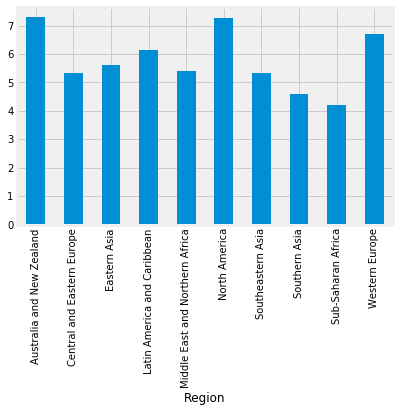

In [16]:
countries_df.groupby('Region')['Happiness Score'].mean().plot.bar()

In [31]:
countries_df.corr()['Happiness Score']

Happiness Score                                             1.000000
Economy (GDP per Capita)                                    0.780966
Family                                                      0.740605
Health (Life Expectancy)                                    0.724200
Freedom                                                     0.568211
Population                                                 -0.022815
Population growth rate                                     -0.394130
Birth rate                                                 -0.664718
Death rate                                                 -0.274280
Net migration rate                                          0.396234
Maternal mortality rate                                    -0.609873
Infant mortality rate                                      -0.698953
Life expectancy at birth                                    0.736428
Total fertility rate                                       -0.626467
HIV/AIDS - adult prevalence rate  

In [18]:
countries_df.columns.values

array(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom',
       'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual',
       'Area', 'Population', 'Population growth rate', 'Birth rate',
       'Death rate', 'Net migration rate', 'Maternal mortality rate',
       'Infant mortality rate', 'Life expectancy at birth',
       'Total fertility rate', 'Health expenditures',
       'HIV/AIDS - adult prevalence rate',
       'HIV/AIDS - people living with HIV/AIDS', 'HIV/AIDS - deaths',
       'Obesity - adult prevalence rate',
       'Children under the age of 5 years underweight',
       'Education expenditures', 'Unemployment, youth ages 15-24',
       'GDP (purchasing power parity)', 'GDP - real growth rate',
       'GDP - per capita (PPP)', 'Gross national saving',
       'Industrial production growth rate', 'Labor force',
       'Unemployment rate', 'Distribu

In [19]:
#Now I am going to drop some unnecessary columns

In [20]:
countries_df = countries_df.drop(['Happiness Rank', 'Reserves of foreign exchange and gold', 
                                  'Standard Error', 'Dystopia Residual', 'Generosity', 
                                  'Trust (Government Corruption)', 'Area', 'Gross national saving', 
                                  'Inflation rate (consumer prices)', 'Central bank discount rate', 
                                  'Commercial bank prime lending rate', 'Stock of narrow money', 
                                  'Stock of broad money', 'Stock of domestic credit', 
                                  'Market value of publicly traded shares', 'Current account balance', 
                                  'Stock of direct foreign investment - at home', 
                                  'Stock of direct foreign investment - abroad', 'Military expenditures'], axis=1)


In [21]:
countries_df.columns.values

array(['Country', 'Region', 'Happiness Score', 'Economy (GDP per Capita)',
       'Family', 'Health (Life Expectancy)', 'Freedom', 'Population',
       'Population growth rate', 'Birth rate', 'Death rate',
       'Net migration rate', 'Maternal mortality rate',
       'Infant mortality rate', 'Life expectancy at birth',
       'Total fertility rate', 'Health expenditures',
       'HIV/AIDS - adult prevalence rate',
       'HIV/AIDS - people living with HIV/AIDS', 'HIV/AIDS - deaths',
       'Obesity - adult prevalence rate',
       'Children under the age of 5 years underweight',
       'Education expenditures', 'Unemployment, youth ages 15-24',
       'GDP (purchasing power parity)', 'GDP - real growth rate',
       'GDP - per capita (PPP)', 'Industrial production growth rate',
       'Labor force', 'Unemployment rate',
       'Distribution of family income - Gini index',
       'Taxes and other revenues', 'Budget surplus (+) or deficit (-)',
       'Public debt', 'Exports', 'Imports'

A lot of these columns are useless as they are right now because the raw numbers aren't taken with respect to population. For all columns that are affected by the number of people in a country, we will now make these columns per capita.

In [22]:
countries_df["Health expenditures per capita"] = countries_df["Health expenditures"] / countries_df["Population"]
countries_df = countries_df.drop(['Health expenditures'], axis=1)

countries_df["People living with HIV/AIDS per capita"] = countries_df["HIV/AIDS - people living with HIV/AIDS"] / countries_df["Population"]
countries_df = countries_df.drop(["HIV/AIDS - people living with HIV/AIDS"], axis=1)

countries_df["HIV/AIDS - deaths per capita"] = countries_df["HIV/AIDS - deaths"] / countries_df["Population"]
countries_df = countries_df.drop(['HIV/AIDS - deaths'], axis=1)

countries_df["Children under the age of 5 years underweight per capita"] = countries_df["Children under the age of 5 years underweight"]/countries_df["Population"]
countries_df = countries_df.drop(["Children under the age of 5 years underweight"], axis=1)

countries_df["Education expenditures per capita"] = countries_df["Education expenditures"]/countries_df["Population"]
countries_df = countries_df.drop(["Education expenditures"], axis=1)

countries_df["Telephones - fixed lines per capita"] = countries_df["Telephones - fixed lines"]/countries_df["Population"]
countries_df = countries_df.drop(["Telephones - fixed lines"], axis=1)

countries_df["Mobile phones per capita"] = countries_df["Telephones - mobile cellular"]/countries_df["Population"]
countries_df = countries_df.drop(["Telephones - mobile cellular"], axis=1)

countries_df["Internet users per capita"] = countries_df["Internet users"]/countries_df["Population"]
countries_df = countries_df.drop(['Internet users'], axis=1)

I do not believe that railways or waterways will prove to be effective in searching for happiness, especially when comparing country happiness to US statewide happiness, so I will remove that column.

In [23]:
countries_df = countries_df.drop(['Railways', 'Waterways'], axis=1)
countries_df["Airports per capita"] = countries_df["Airports"]/countries_df["Population"]
countries_df["Roadways per capita"] = countries_df["Roadways"]/countries_df["Population"]
countries_df = countries_df.drop(['Airports', 'Roadways'], axis=1)
countries_df.columns.values

array(['Country', 'Region', 'Happiness Score', 'Economy (GDP per Capita)',
       'Family', 'Health (Life Expectancy)', 'Freedom', 'Population',
       'Population growth rate', 'Birth rate', 'Death rate',
       'Net migration rate', 'Maternal mortality rate',
       'Infant mortality rate', 'Life expectancy at birth',
       'Total fertility rate', 'HIV/AIDS - adult prevalence rate',
       'Obesity - adult prevalence rate',
       'Unemployment, youth ages 15-24', 'GDP (purchasing power parity)',
       'GDP - real growth rate', 'GDP - per capita (PPP)',
       'Industrial production growth rate', 'Labor force',
       'Unemployment rate', 'Distribution of family income - Gini index',
       'Taxes and other revenues', 'Budget surplus (+) or deficit (-)',
       'Public debt', 'Exports', 'Imports', 'Debt - external',
       'Electricity - production', 'Electricity - consumption',
       'Electricity - exports', 'Electricity - imports',
       'Electricity - installed generating capa

In [24]:
per_capita_income_df = pd.read_csv('Per Capita Income.csv')
countries_df = countries_df.merge(per_capita_income_df, how = 'left', left_on = 'Country', right_on = 'Country Name')

In [25]:
countries_df.drop('Country Name', axis = 1)
countries_df.rename({'2015': 'Income Per Capita from World Bank'})

,Country,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Population,Population growth rate,Birth rate,...,HIV/AIDS - deaths per capita,Children under the age of 5 years underweight per capita,Education expenditures per capita,Telephones - fixed lines per capita,Mobile phones per capita,Internet users per capita,Airports per capita,Roadways per capita,Country Name,2015
0,Switzerland,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,8.121830e+06,0.71,10.50,...,0.000037,NaN,6.402498e-07,0.538056,1.415937,0.874187,7.756873e-06,0.008799,Switzerland,63938.979980
1,Iceland,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,3.319180e+05,1.21,13.91,...,NaN,NaN,2.289722e-05,0.512175,1.114733,0.953247,2.892281e-04,0.038835,Iceland,48728.099360
2,Denmark,Western Europe,7.527,1.32548,1.36058,0.87464,0.64938,5.581503e+06,0.22,10.27,...,0.000018,NaN,1.558720e-06,0.336827,1.272059,0.967481,1.433306e-05,0.013245,Denmark,49058.501070
3,Norway,Western Europe,7.522,1.45900,1.33095,0.88521,0.66973,5.207689e+06,1.13,12.14,...,0.000019,NaN,1.324964e-06,0.222748,1.132940,0.940916,1.824226e-05,0.018025,Norway,60519.971520
4,Canada,North America,7.427,1.32629,1.32261,0.90563,0.63297,3.509984e+07,0.75,10.28,...,0.000011,NaN,1.538469e-07,0.472937,0.840460,0.923081,4.179507e-05,0.029695,Canada,44567.866350
5,Finland,Western Europe,7.406,1.29025,1.31826,0.88911,0.64169,5.476922e+06,0.40,10.72,...,NaN,NaN,1.241573e-06,0.116854,1.387641,0.931180,2.702248e-05,0.014242,Finland,42220.957670
6,Netherlands,Western Europe,7.378,1.32944,1.28017,0.89284,0.61576,1.694790e+07,0.41,10.83,...,NaN,NaN,3.481256e-07,0.420701,1.156485,0.955870,1.711126e-06,0.008219,Netherlands,50302.067750
7,Sweden,Western Europe,7.364,1.33171,1.28907,0.91087,0.65980,9.801616e+06,0.80,11.99,...,0.000010,NaN,7.141679e-07,0.389732,1.254895,0.887609,2.356754e-05,0.059129,Sweden,48436.975120
8,New Zealand,Australia and New Zealand,7.286,1.25018,1.31967,0.90837,0.63938,4.438393e+06,0.82,13.33,...,NaN,NaN,1.667270e-06,0.416818,1.149065,0.901227,2.771273e-05,0.021215,New Zealand,37475.178360
9,Australia,Australia and New Zealand,7.284,1.33358,1.30923,0.93156,0.65124,2.275101e+07,1.07,12.15,...,0.000004,8.790817e-09,2.461429e-07,0.403938,1.362577,0.887873,2.109796e-05,0.036184,Australia,46270.197400


In [26]:
countries_df.corr()['Happiness Score']

Happiness Score                                             1.000000
Economy (GDP per Capita)                                    0.780966
Family                                                      0.740605
Health (Life Expectancy)                                    0.724200
Freedom                                                     0.568211
Population                                                 -0.022815
Population growth rate                                     -0.394130
Birth rate                                                 -0.664718
Death rate                                                 -0.274280
Net migration rate                                          0.396234
Maternal mortality rate                                    -0.609873
Infant mortality rate                                      -0.698953
Life expectancy at birth                                    0.736428
Total fertility rate                                       -0.626467
HIV/AIDS - adult prevalence rate  

## County Data

In [27]:
state_pop_df = pd.read_csv('PopulationEstimates.csv')
state_pop_df.head()

,FIPS,State,Area_Name,Census Pop 2010,Estimates Base 2010,Pop Estimate 2010,Pop Estimate 2011,Pop Estimate 2012,Pop Estimate 2013,Pop Estimate 2014,...,Natural increase rate 2017,Natural increase rate 2018,Net migration rate 2011,Net migration rate 2012,Net migration rate 2013,Net migration rate 2014,Net migration rate 2015,Net migration rate 2016,Net migration rate 2017,Net migration rate 2018
0,0,US,United States,"308,745,538","308,758,105","309,326,085","311,580,009","313,874,218","316,057,727","318,386,421",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,AL,Alabama,"4,779,736","4,780,138","4,785,448","4,798,834","4,815,564","4,830,460","4,842,481",...,1.1,0.8,0.5,1.2,1.6,0.6,0.6,0.8,1.1,1.9
2,1001,AL,Autauga County,"54,571","54,574","54,754","55,208","54,936","54,713","54,876",...,2.7,2.2,6.0,-6.1,-3.9,2.0,-1.9,5.3,1.0,0.6
3,1003,AL,Baldwin County,"182,265","182,264","183,111","186,540","190,143","194,886","199,189",...,0.8,0.1,16.3,17.6,22.9,20.2,17.9,21.5,22.5,24.8
4,1005,AL,Barbour County,"27,457","27,457","27,330","27,350","27,174","26,944","26,758",...,-1.0,-2.5,0.3,-6.8,-8.1,-5.1,-15.5,-18.2,-25.0,-8.6


In [28]:
state_pop_df = state_pop_df[state_pop_df.columns.drop(list(state_pop_df.filter(regex='Unnamed')))]
state_pop_df.head()

,FIPS,State,Area_Name,Census Pop 2010,Estimates Base 2010,Pop Estimate 2010,Pop Estimate 2011,Pop Estimate 2012,Pop Estimate 2013,Pop Estimate 2014,...,Natural increase rate 2017,Natural increase rate 2018,Net migration rate 2011,Net migration rate 2012,Net migration rate 2013,Net migration rate 2014,Net migration rate 2015,Net migration rate 2016,Net migration rate 2017,Net migration rate 2018
0,0,US,United States,"308,745,538","308,758,105","309,326,085","311,580,009","313,874,218","316,057,727","318,386,421",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,AL,Alabama,"4,779,736","4,780,138","4,785,448","4,798,834","4,815,564","4,830,460","4,842,481",...,1.1,0.8,0.5,1.2,1.6,0.6,0.6,0.8,1.1,1.9
2,1001,AL,Autauga County,"54,571","54,574","54,754","55,208","54,936","54,713","54,876",...,2.7,2.2,6.0,-6.1,-3.9,2.0,-1.9,5.3,1.0,0.6
3,1003,AL,Baldwin County,"182,265","182,264","183,111","186,540","190,143","194,886","199,189",...,0.8,0.1,16.3,17.6,22.9,20.2,17.9,21.5,22.5,24.8
4,1005,AL,Barbour County,"27,457","27,457","27,330","27,350","27,174","26,944","26,758",...,-1.0,-2.5,0.3,-6.8,-8.1,-5.1,-15.5,-18.2,-25.0,-8.6


In [29]:
state_pop_df = state_pop_df.drop(0)
state_pop_df.head()

,FIPS,State,Area_Name,Census Pop 2010,Estimates Base 2010,Pop Estimate 2010,Pop Estimate 2011,Pop Estimate 2012,Pop Estimate 2013,Pop Estimate 2014,...,Natural increase rate 2017,Natural increase rate 2018,Net migration rate 2011,Net migration rate 2012,Net migration rate 2013,Net migration rate 2014,Net migration rate 2015,Net migration rate 2016,Net migration rate 2017,Net migration rate 2018
1,1000,AL,Alabama,"4,779,736","4,780,138","4,785,448","4,798,834","4,815,564","4,830,460","4,842,481",...,1.1,0.8,0.5,1.2,1.6,0.6,0.6,0.8,1.1,1.9
2,1001,AL,Autauga County,"54,571","54,574","54,754","55,208","54,936","54,713","54,876",...,2.7,2.2,6.0,-6.1,-3.9,2.0,-1.9,5.3,1.0,0.6
3,1003,AL,Baldwin County,"182,265","182,264","183,111","186,540","190,143","194,886","199,189",...,0.8,0.1,16.3,17.6,22.9,20.2,17.9,21.5,22.5,24.8
4,1005,AL,Barbour County,"27,457","27,457","27,330","27,350","27,174","26,944","26,758",...,-1.0,-2.5,0.3,-6.8,-8.1,-5.1,-15.5,-18.2,-25.0,-8.6
5,1007,AL,Bibb County,"22,915","22,920","22,872","22,747","22,664","22,516","22,541",...,2.3,-0.3,-5.0,-3.8,-5.7,1.1,1.5,-0.8,-3.1,-6.6


In [30]:
state_unemployment_df = pd.read_csv('Unemployment.csv')
state_unemployment_df = state_unemployment_df[state_unemployment_df.columns.drop(list(state_unemployment_df.filter(regex='Unnamed')))]
state_unemployment_df = state_unemployment_df.drop(0)
state_unemployment_df.head()

,FIPS,State,Area_name,Unemployment_rate_2007,Unemployment_rate_2008,Unemployment_rate_2009,Unemployment_rate_2010,Unemployment_rate_2011,Unemployment_rate_2012,Unemployment_rate_2013,Unemployment_rate_2014,Unemployment_rate_2015,Unemployment_rate_2016,Unemployment_rate_2017,Unemployment_rate_2018,Median_Household_Income_2017,Med_HH_Income_Percent_of_State_Total_2017
1,1000.0,AL,Alabama,4.0,5.7,11.0,10.5,9.6,8.0,7.2,6.8,6.1,5.8,4.4,3.9,"$48,193",100.0
2,1001.0,AL,"Autauga County, AL",3.3,5.1,9.7,8.9,8.4,6.9,6.2,5.8,5.2,5.1,3.9,3.6,"$58,343",121.1
3,1003.0,AL,"Baldwin County, AL",3.1,4.6,9.8,10.0,9.0,7.5,6.6,6.1,5.5,5.3,4.1,3.6,"$56,607",117.5
4,1005.0,AL,"Barbour County, AL",6.3,8.8,14.3,12.3,11.5,11.5,10.2,10.5,8.9,8.3,5.8,5.2,"$32,490",67.4
5,1007.0,AL,"Bibb County, AL",4.1,5.8,13.3,11.4,10.5,8.5,7.9,7.2,6.6,6.4,4.4,4.0,"$45,795",95.0
